In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from numpy import loadtxt
from numpy import savetxt
from scipy.sparse.linalg import expm, expm_multiply
from scipy import sparse

In [3]:
"Now we import and preprocess the registers"
"We import the registers"
n_Delta=100 
Delta_vec=np.linspace(1,5,n_Delta)

Delta_class=list(range(n_Delta))


diccionario_clases=dict(zip(Delta_vec,Delta_class))




out_name = "C:/Users/Manuel/Desktop/universidad/beca_gefes_2021/proyecto/archivos_clicks/n_Delta_100_n_clicks_100/clicks_deltas_Omega_3.csv"

Deltas_and_clicks=loadtxt(out_name,delimiter=",")
Deltas_and_clicks = np.random.permutation(Deltas_and_clicks)


y_full=Deltas_and_clicks[:,0] 
X_full=Deltas_and_clicks[:,1:] 

"We are only interested in the time difference between photons"
X_full[:,1:]=X_full[:,1:]-X_full[:,:-1]



ratio=0.8
limit=int(ratio*len(y_full))
y_train,y_valid=y_full[:limit],y_full[limit:]

"We reescale the photon times so that the inputs are between 0 and 1 as it is in that range where we have"
"the most expresivity of the activation functions"
maxX=np.amax(X_full)
X_train,X_valid=X_full[:limit,:]/maxX,X_full[limit:,:]/maxX





In [4]:
es = EarlyStopping(monitor='val_loss', 
                       mode='min', verbose=1, patience=10, min_delta=0.01, 
                       restore_best_weights=True)

nn_regression=keras.models.Sequential([
 
    keras.layers.Dense(300,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(100,activation="relu"),
    keras.layers.Dense(1,activation="linear")

    # El activador es softmax para que salga una distribucion normalizada


    ])
nn_regression.compile(loss=tf.keras.losses.MeanSquaredError(), 
                                optimizer="sgd",metrics=["mse"])
nn_regression.fit( X_train, y_train, epochs = 50,
                            validation_data = (X_valid, y_valid), 
                            callbacks = [es])

Epoch 1/50
2500/2500 [==============================] - 6s 2ms/step - loss: 0.3418 - mse: 0.3418 - val_loss: 0.2385 - val_mse: 0.2385
Epoch 2/50
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2274 - mse: 0.2274 - val_loss: 0.2314 - val_mse: 0.2314
Epoch 3/50
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2152 - mse: 0.2152 - val_loss: 0.2097 - val_mse: 0.2097
Epoch 4/50
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2132 - mse: 0.2132 - val_loss: 0.2107 - val_mse: 0.2107
Epoch 5/50
2500/2500 [==============================] - 6s 2ms/step - loss: 0.2120 - mse: 0.2120 - val_loss: 0.2093 - val_mse: 0.2093
Epoch 6/50
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2113 - mse: 0.2113 - val_loss: 0.2096 - val_mse: 0.2096
Epoch 7/50
2500/2500 [==============================] - 5s 2ms/step - loss: 0.2110 - mse: 0.2110 - val_loss: 0.2143 - val_mse: 0.2143
Epoch 8/50
2500/2500 [==============================] - 5s 2ms

In [12]:
def aggregated_prediction(model, register, Delta_vec):
    "We manually increase the uncertainty"
    uncertainty_coef = 8
    n_perm = int(len(register)/5)
    perm_matrix = np.zeros([n_perm, len(register)])
    for i in range(n_perm):
        perm_matrix[i, :] = np.random.permutation(register)
    pred = model.predict(perm_matrix)
    mean, std = np.mean(pred), np.std(pred)
    prob_density = np.exp(-(Delta_vec-mean)**2/(uncertainty_coef*2*std**2))
    prob_density = prob_density /  np.sum(prob_density)
    return prob_density


def logS_t(Omega,Delta,t):
    #Te calcula la matriz que debes exponenciar
    #para tener S(t), introduces la Omega y el tiempo como argumento
    aux=np.matrix(np.zeros((4,4)),dtype=complex)
    aux[0,1]=1j*t*Omega
    aux[0,2]=-1j*t*Omega
    aux[1,0]=1j*t*Omega
    aux[1,1]=t*(-1/2+1j*Delta)
    aux[1,3]=-1j*t*Omega
    aux[2,0]=-1j*t*Omega
    aux[2,2]=t*(-1/2-1j*Delta)
    aux[2,3]=1j*t*Omega
    aux[3,1]=-1j*t*Omega
    aux[3,2]=1j*t*Omega
    aux[3,3]=-1*t
    
    return aux


def trace_liouv(density_matrix):
    #aquí defino una función auxiliar que me 
    #saca la traza de la matriz densidad cuando está dada en forma vector
    return density_matrix[0]+density_matrix[3]


def delta_prob_distribution(clicks_processed, Delta_vec, Omega):
    J=np.matrix(np.zeros((4,4)))
    J[0,3]=1
    J=sparse.csr_matrix(J)
    n_Delta=len(Delta_vec)
    
    
    # Definimos las matrices densidad en el instante inicial
    ro_0=np.asarray([1,0,0,0],dtype=complex)
    
    prob_matrix=np.zeros(n_Delta)
    
    for j in range(n_Delta):
        Delta=Delta_vec[j]
        ro=ro_0
        for i in range(len(clicks_processed)):
            t=clicks_processed[i]
            ro=expm(logS_t(Omega,Delta,t)).dot(ro)
            ro=J.dot(ro)
            #print(trace_liouv(ro_list[j]).real)
        prob_matrix[j]=trace_liouv(ro).real
        #print("j= "+str(j))
    prob_matrix_normalised=prob_matrix/(np.sum(prob_matrix[:]))
    
    return prob_matrix_normalised

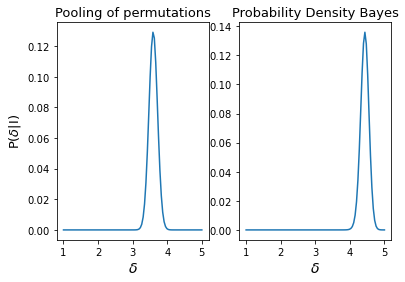

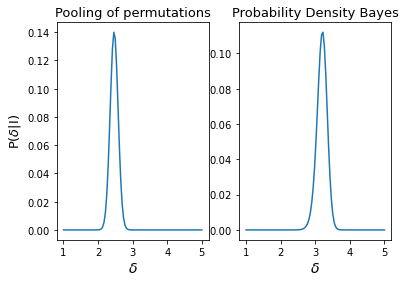

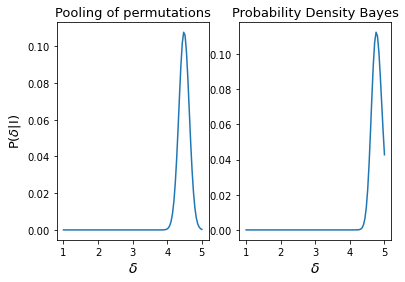

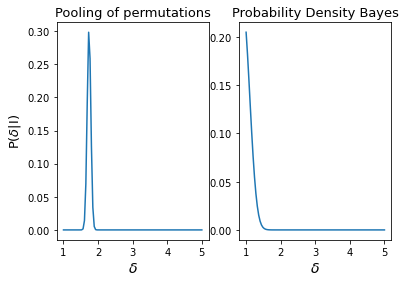

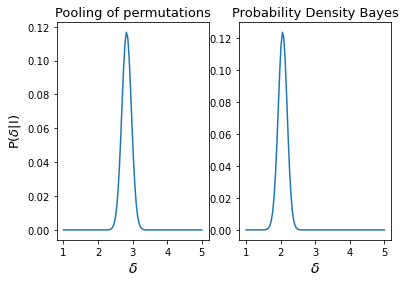

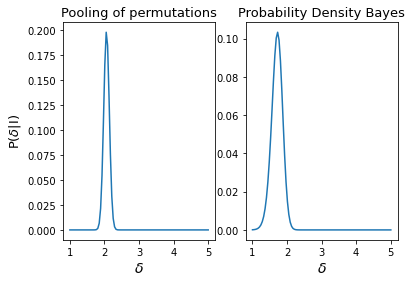

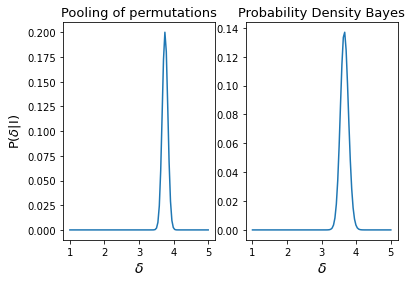

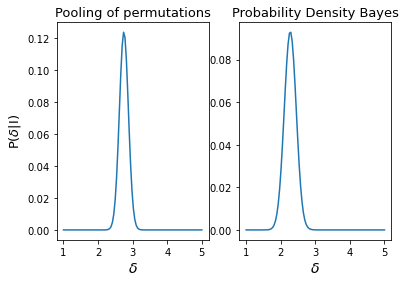

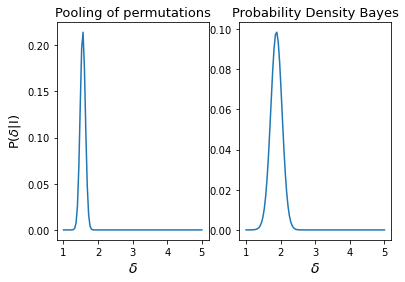

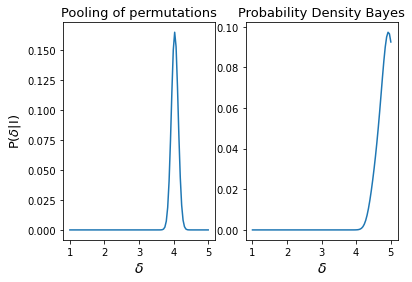

In [13]:
for n_reg in range(10):
    prob_density_perm = aggregated_prediction(nn_regression, X_valid[n_reg, :], Delta_vec)
    plt.subplot(1, 2, 1)
    plt.plot(Delta_vec, prob_density_perm)
    plt.xlabel("$\delta$",fontsize=14)
    plt.ylabel(r"P($\delta$|I)",fontsize=13)
    plt.title(r"Pooling of permutations",fontsize=13)
    
    prob_density_bayes = delta_prob_distribution(X_valid[n_reg, :]*maxX, 
                                                 Delta_vec, Omega = 3)
    
    
    plt.subplot(1, 2, 2)
    plt.plot(Delta_vec, prob_density_bayes)
    plt.xlabel("$\delta$",fontsize=14)
    plt.title(r"Probability Density Bayes",fontsize=13)
    plt.show()